In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
#
import pathlib
from IPython import display
import functools
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import time
from tqdm import tqdm
# from mitdeeplearning import as mdl
import cv2 as cv
import os
from datetime import datetime
import funcs as ff


# check that the environment is fine
print('TensorFlow version : ', tf.__version__ )
print('NumPy version : ', np.__version__ )
print('OpenCV version', cv.__version__)
print('keras version : ', tf.keras.__version__)

AUTOTUNE = tf.data.experimental.AUTOTUNE

/opt/homebrew/Caskroom/miniforge/base/envs/tf-arm/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:54: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.4.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.0-rc0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


TensorFlow version :  2.4.0-rc0
NumPy version :  1.20.1
OpenCV version 4.5.1
keras version :  2.4.0


In [2]:
'''
DIRECTORY SETTINGS
'''
cwd = '/Volumes/Seagate Backup Plus Drive/datasets/EXPERIMENTS'#os.getcwd()

serie_dir = os.path.join(cwd, 'Embeddings')
if not os.path.isdir(serie_dir):
    os.makedirs(serie_dir)

exp_dir = os.path.join(serie_dir, 'vae-16-from-scratch')
if not os.path.isdir(exp_dir):
    os.makedirs(exp_dir)

now = datetime.now().strftime('%b%d-%Y')
print(now)
date_dir = os.path.join(exp_dir, now)
if not os.path.isdir(date_dir):
    os.makedirs(date_dir)

last_ckpt = os.path.join(exp_dir, 'last_model')
if not os.path.isdir(last_ckpt):
  os.mkdir(last_ckpt)

print('cwd : ', cwd)
print('serie dir : ', serie_dir)
print('exp_dir : ', exp_dir)
print('date_ dir : ', date_dir)
print('last ckpt dir : ', last_ckpt)


PermissionError: [Errno 13] Permission denied: '/Volumes/Seagate Backup Plus Drive'

In [3]:

def record_parser(example):
    example_fmt = {
        'label': tf.io.FixedLenFeature([14], tf.float32),
        'image': tf.io.FixedLenFeature([],tf.string, default_value='')}
    parsed = tf.io.parse_single_example(example, example_fmt)
    image = tf.io.decode_png(parsed["image"],channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, parsed['label']

def reduce_channels(x, y):
    return tf.expand_dims((x[:, :, 0] + x[:, :, 1] + x[:, :, 2])/3, axis=-1)

def make_dataset(filename):
    base_path = '/Volumes/Seagate Backup Plus Drive/datasets/chexpert-tfrecords'
    full_path = os.path.join(base_path,filename)
    dataset = tf.data.TFRecordDataset(full_path)
    parsed_dataset = dataset.map(record_parser,num_parallel_calls = AUTOTUNE)
    parsed_dataset = parsed_dataset.map(reduce_channels,num_parallel_calls = AUTOTUNE)

    return parsed_dataset

batch_size = 32

train_ds = make_dataset('new_training_cropped.tfrecords').batch(batch_size, True).shuffle(512).prefetch(1)
val_ds = make_dataset('validation_cropped.tfrecords')
test_ds = make_dataset('test_set_cropped.tfrecords')
label_names = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
                'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

In [1]:
from tensorflow.python.framework.ops import disable_eager_execution

#disable_eager_execution()

from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D

def get_encoder_network(x, num_filters):
    x = Conv2D(num_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = Conv2D(num_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = MaxPooling2D()(x)
    return x

def get_decoder_network(x, num_filters):
    x = UpSampling2D()(x)
    x = Conv2D(num_filters, 3, activation='relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    x = Conv2D(num_filters, 3, activation='relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    return x


from tensorflow.keras.layers import Input, Dense, Reshape, Concatenate, Flatten, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

# function to create an autoencoder network
def get_vae(height, width, batch_size, latent_dim,
            is_variational=True, conditioning_dim=0,
            start_filters=8, nb_capacity=3,
            optimizer=Adam(lr=0.001)):

    # INPUT ##

    # create layer for input image
    # concatenate image metadata
    inputs = Input((height, width, 1))
    if conditioning_dim > 0:
        condition = Input([conditioning_dim])
        condition_up = Dense(height * width)(condition)
        condition_up = Reshape([height, width, 1])(condition_up)
        inputs_new = Concatenate(axis=3)([inputs, condition_up])
    else:
        inputs_new = inputs


    # ENCODER ##

    # create encoding layers
    # duplicate the encoding layers with increasing filters
    eblock = get_encoder_network(inputs_new, start_filters)
    for i in range(1, nb_capacity+1):
        eblock = get_encoder_network(eblock, start_filters*(2**i))

    # create latent space layer
    _, *shape_spatial = eblock.get_shape().as_list()
    eblock_flat = Flatten()(eblock)
    if not is_variational:
        z = Dense(latent_dim)(eblock_flat)
    else:
        # sample latent values from a normal distribution
        def sampling(args):
            z_mu, z_ls = args
            epsilon = tf.random.normal(shape=(batch_size, latent_dim))
            return z_mu + tf.exp(z_ls) * epsilon

        z_mean = Dense(latent_dim)(eblock_flat)
        z_log_sigma = Dense(latent_dim)(eblock_flat)
        z = Lambda(sampling, output_shape=(latent_dim))([z_mean, z_log_sigma])

    if conditioning_dim > 0:
        z_ext = Concatenate()([z, condition])


    ## DECODER ##

    # create decoding layers
    inputs_embedding = Input([latent_dim + conditioning_dim])
    embedding = Dense(np.prod(shape_spatial), activation='relu')(inputs_embedding)
    embedding = Reshape(eblock.shape.as_list()[1:])(embedding)

    # duplicate the encoding layers with increasing filters
    dblock = get_decoder_network(embedding, start_filters*(2**nb_capacity))
    for i in range(nb_capacity-1, -1, -1):
        dblock = get_decoder_network(dblock, start_filters*(2**i))

    output = Conv2D(1, 1, activation = 'tanh')(dblock)

    ## VAE ##

    # put encoder, decoder together
    decoder = Model(inputs_embedding, output)
    if conditioning_dim > 0:
        encoder_with_sampling = Model([inputs, condition], z)
        encoder_with_sampling_ext = Model([inputs, condition], z_ext)
        vae_out = decoder(encoder_with_sampling_ext([inputs, condition]))
        vae = Model([inputs, condition], vae_out)
    else:
        encoder_with_sampling = Model(inputs, z)
        vae_out = decoder(encoder_with_sampling(inputs))
        vae = Model(inputs, [vae_out, z_mean, z_log_sigma])

    # define the VAE loss as the sum of MSE and KL-divergence loss
    def vae_loss(x, x_decoded_mean):
        #x_decoded_mean, z_mean, z_log_sigma = args
        mse_loss = K.mean(K.square(x - x_decoded_mean), axis=(1,2))# * height * width
        kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
        return mse_loss + kl_loss

    if is_variational:
        vae.compile(loss=vae_loss, optimizer=optimizer)
    else:
        vae.compile(loss='mse', optimizer=optimizer)

    vae.summary()

    return vae, encoder_with_sampling, decoder

# hyperparameters
VARIATIONAL = True
HEIGHT = 224
WIDTH = 224
BATCH_SIZE = 32
LATENT_DIM = 32
START_FILTERS = 16
CAPACITY = 3
CONDITIONING = False
OPTIMIZER = Adam(lr=5e-4)

vae, encoder, decoder = get_vae(is_variational=VARIATIONAL,
                                   height=HEIGHT,
                                   width=WIDTH,
                                   batch_size=BATCH_SIZE,
                                   latent_dim=LATENT_DIM,
                                   conditioning_dim=0,
                                   start_filters=START_FILTERS,
                                   nb_capacity=CAPACITY,
                                   optimizer=OPTIMIZER)

NameError: name 'tf' is not defined

In [5]:
#ds = tf.data.Dataset.zip((train_ds, train_ds))

# train the variational autoencoder
#history=vae.fit(x=ds, verbose=2, epochs=5)

In [6]:

'''
# ###############
# TRAINING LOOP FUNCTIONS
# ###############
'''
lr = 5e-4
epochs = 10
optimizer = tf.keras.optimizers.Adam(lr)

def vae_loss(x, x_decoded_mean, z_mean, z_log_sigma):
    mse_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(x, x_decoded_mean), axis=(1,2))
    kl_loss = - 0.5 * tf.reduce_mean(1 + z_log_sigma - tf.square(z_mean) - tf.exp(z_log_sigma), axis=-1)
    return mse_loss + kl_loss

# Training step with gradient tapes
@tf.function
def vae_train_step(x, optimizer):

  with tf.GradientTape() as tape:
    # Feed input x into dbvae. Note that this is using the DB_VAE call function!
    x_rec, zm, zls = vae(x)
    loss = vae_loss(x, x_rec, zm, zls)
  grads = tape.gradient(loss, vae.trainable_variables)
  # apply gradients to variables
  optimizer.apply_gradients(zip(grads, vae.trainable_variables))
  return loss

In [7]:
helper = ff.TrainingUtility(
    model_names_list=['vae-from-scratch']
)

for epoch in tqdm(range(epochs)):
    start_time = time.time()
    #train_ds = train_ds.shuffle(550)
    count = 0
    for x in train_ds.take(5):
        count += 1

        with tf.GradientTape() as tape:
            # Feed input x into dbvae. Note that this is using the DB_VAE call function!
            x_rec, zm, zls = vae(x)
            loss = vae_loss(x, x_rec, zm, zls)
        grads = tape.gradient(loss, vae.trainable_variables)
        optimizer.apply_gradients(zip(grads, vae.trainable_variables))


        if not bool(count%100):
            helper.save_model([vae], path=last_ckpt, suffix='-last.hdf5'.format(epoch))
            print('saved ckpt\n time for {} iterations : {}'.format(count, time.time()-start_time))
            count = 0

    end_time = time.time()
    train_time = end_time - start_time
    print('time elapsed : {}s'.format(train_time))
    print('last loss : {}'.format(loss))
    helper.save_model([vae], path=date_dir, suffix='-epoch_{}.hdf5'.format(epoch))

  0%|          | 0/10 [00:00<?, ?it/s]

time elapsed : 21.31092405319214s
last loss : [1.0290363  0.8885286  1.1277546  1.0435228  0.8332561  0.98119175
 0.9671027  0.8628417  0.8347088  1.0557401  1.0201485  1.0897176
 1.0005683  1.0538745  1.0004554  0.5496763 ]


 10%|█         | 1/10 [00:21<03:14, 21.60s/it]

time elapsed : 28.176302909851074s
last loss : [0.19408426 0.1631493  0.15081643 0.1703341  0.16285226 0.16492817
 0.21974267 0.21046962 0.19373861 0.15905707 0.13411239 0.12037076
 0.19100036 0.20934714 0.1722205  0.17386049]


 20%|██        | 2/10 [00:49<03:24, 25.59s/it]

time elapsed : 24.300127029418945s
last loss : [0.10690089 0.07247013 0.04912597 0.06774368 0.12269802 0.09132884
 0.15002915 0.05571173 0.05727036 0.10427529 0.07267199 0.15428199
 0.07667024 0.07404584 0.07399721 0.18800002]


 30%|███       | 3/10 [01:14<02:55, 25.05s/it]

time elapsed : 27.135777711868286s
last loss : [0.14168854 0.09366897 0.11443948 0.11776347 0.07583506 0.10980314
 0.11702791 0.08913775 0.08227431 0.09781709 0.11728135 0.08255773
 0.08546653 0.09676112 0.10120009 0.08619124]


 40%|████      | 4/10 [01:41<02:35, 25.96s/it]

time elapsed : 31.450514793395996s
last loss : [0.06567221 0.07287802 0.10626958 0.08259892 0.10559628 0.06479318
 0.07216498 0.04459016 0.05485579 0.04768256 0.03452265 0.07669684
 0.0637746  0.05124228 0.05296107 0.05163097]


 50%|█████     | 5/10 [02:13<02:19, 27.99s/it]

time elapsed : 30.770300149917603s
last loss : [0.05707686 0.06849043 0.06505956 0.04299697 0.04738025 0.045268
 0.03231412 0.03887529 0.03708611 0.04227294 0.04121577 0.06995038
 0.03987479 0.08346321 0.05720628 0.06568412]


 60%|██████    | 6/10 [02:44<01:56, 29.02s/it]

time elapsed : 30.22686004638672s
last loss : [0.05322548 0.05718098 0.03637248 0.03078248 0.07814454 0.03350968
 0.03784311 0.02871911 0.03426638 0.03735138 0.02951553 0.03724153
 0.04840998 0.02471149 0.030437   0.04757325]


 70%|███████   | 7/10 [03:14<01:28, 29.45s/it]

time elapsed : 29.175763845443726s
last loss : [0.03268943 0.02637463 0.03905082 0.05037712 0.03845987 0.0683816
 0.02852522 0.02201685 0.06462531 0.03489288 0.03462361 0.03249569
 0.04146184 0.05150636 0.03206843 0.04126098]


 80%|████████  | 8/10 [03:44<00:58, 29.49s/it]

time elapsed : 25.83332085609436s
last loss : [0.04712766 0.05915118 0.04185032 0.03202444 0.02616707 0.04209978
 0.02133566 0.06179893 0.06118226 0.04061275 0.03571786 0.02663473
 0.03589915 0.05761804 0.03519338 0.04977748]


 90%|█████████ | 9/10 [04:10<00:28, 28.42s/it]

time elapsed : 35.62024784088135s
last loss : [0.04319381 0.05364786 0.06093185 0.04774331 0.04185247 0.06632558
 0.03464224 0.02500904 0.0250675  0.05760252 0.0325056  0.06485604
 0.02409234 0.02979079 0.04034928 0.02207206]


100%|██████████| 10/10 [04:46<00:00, 28.62s/it]


ValueError: num must be 1 <= num <= 4, not 5

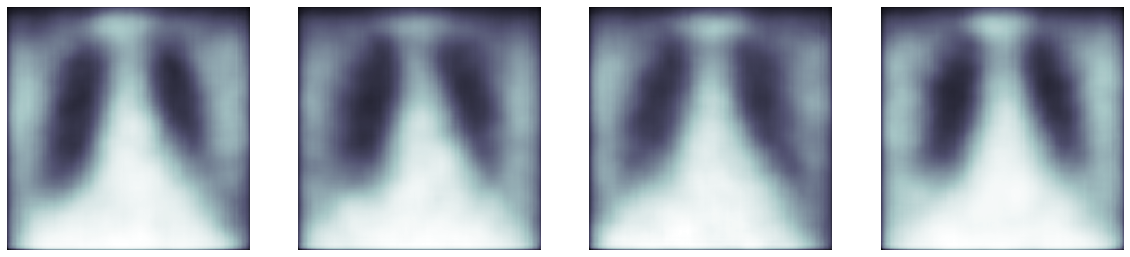

In [14]:
samples = train_ds.take(1)

for x in samples:
    x_rec, zm, zls = vae(x)

    x = ff.normalize_tensor(x)
    x_rec = ff.normalize_tensor(x_rec)
    fig = plt.figure(figsize=(20, 15))
    for i in range(x.shape[0]):
        plt.subplot(1, 4, i + 1)
        plt.imshow(x_rec[i], cmap='bone')
        plt.axis('off')
    fig = plt.figure(figsize=(20, 15))
    plt.show()
